# Machine Learning Prediction - Data Challenge 

## by SNCF-Transilien

##### Code: Isabella RIBEIRO RIGUE et Luigi MELLO RIGATO

Ce [data challenge](https://challengedata.ens.fr/participants/challenges/149/) proposé par SNCF-Transilien a pour objectif de mieux anticiper le nombre de validations quotidiennes dans les gares d'Île-de-France. En tant que principal opérateur de trains de banlieue dans cette région, SNCF-Transilien fait circuler chaque jour plus de 6 200 trains, transportant des millions de voyageurs. Le nombre de validations de cartes à puce augmente régulièrement — environ 6\% par an entre 2015 et 2019 —, ce qui rend crucial de mieux prévoir cette croissance pour adapter les services et améliorer la gestion des flux.

Le but de ce challenge est de construire un modèle capable de prédire, pour chaque gare, le nombre de validations journalières sur le moyen et long terme. Il s’agit d’un problème classique de prévision de séries temporelles, mais la difficulté réside ici dans la gestion d'un grand nombre de séries distinctes, correspondant à chacune des gares. Pour SNCF-Transilien, l'enjeu est de pouvoir anticiper les besoins futurs en termes de transport et d'ajuster l’offre de façon proactive afin de répondre efficacement à la demande croissante.

Nous avons les jeux de données :

- 'train_f_x.csv' : Ce fichier contient les caractéristiques (features) relatives aux validations quotidiennes dans 448 gares du réseau SNCF-Transilien, incluant toutes les stations des lignes RER A et RER B. Il couvre une période allant du 1er janvier 2015 au 31 décembre 2022, soit un total de 2 922 jours d’observation.

- 'y_train_sncf.csv' : Ce fichier comprend un index (qui est la combinaison de la date et de l'identifiant de la station) ainsi que la variable cible y, représentant le nombre de validations. Cette variable est associée aux caractéristiques présentes dans train\_x.csv.

- 'test_f_x_THurtzP.csv' : Ce fichier contient les mêmes caractéristiques (features) que train\_x.csv, mais pour une période plus récente, du 1er janvier 2023 au 30 juin 2023, soit 181 jours. Ce jeu de données est destiné à être utilisé pour prédire les valeurs de y, c’est-à-dire le nombre de validations journalières pour chaque station, en se basant sur le modèle entraîné. \newline 

Nous avons les features:

- date : la date à laquelle les validations ont été enregistrées, au format AAAA-MM-JJ.

- station : identifiant anonymisé de chaque gare codé par une chaîne de trois caractères.

- job : indicateur du Jour Ouvrable de Base (JOB) valant 1 pour les jours de semaine et 0 pour les week-ends.

- ferie : indicateur pour les jours fériés, avec 1 si le jour est férié et 0 sinon.

- vacances : indicateur pour les vacances scolaires, valant 1 si le jour fait partie des vacances scolaires et 0 sinon.

## Importation des données

On commence par importer les librairies qui seront utilisées :

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV, KFold
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

On charge les fichiers et on met un index défault pour tous les dataframes:

In [2]:
file_path = 'data/'

X_train = pd.read_csv(file_path + 'train_f_x.csv') 
y_train = pd.read_csv(file_path + 'y_train_sncf.csv', index_col=0)
X_test = pd.read_csv(file_path + 'test_f_x_THurtzP.csv', index_col=0) 

In [3]:
# Mettre un index défaut pour les dataframes
X_train['index'] = X_train['date'].astype(str) + '_' + X_train['station'].astype(str)
X_train = X_train.set_index('index')

# Transformer les dates en datetime pour mieux les manipuler
X_train['date'] = pd.to_datetime(X_train['date'])
X_test['date'] = pd.to_datetime(X_test['date'])

In [4]:
X_train.head()

,date,station,job,ferie,vacances
index,,,,,
2015-01-01_1J7,2015-01-01,1J7,1,1,1
2015-01-01_O2O,2015-01-01,O2O,1,1,1
2015-01-01_8QR,2015-01-01,8QR,1,1,1
2015-01-01_UMC,2015-01-01,UMC,1,1,1
2015-01-01_FK3,2015-01-01,FK3,1,1,1


In [5]:
y_train.head()

,y
index,
2015-01-01_1J7,7
2015-01-01_O2O,0
2015-01-01_8QR,9
2015-01-01_UMC,9
2015-01-01_FK3,28


## Exploration des données

Tout d’abord, on fait quelques graphiques pour visualiser et essayer de mieux comprendre le comportement des données (s’il existe une tendance, par exemple).

Text(0, 0.5, 'Nombre de validations')

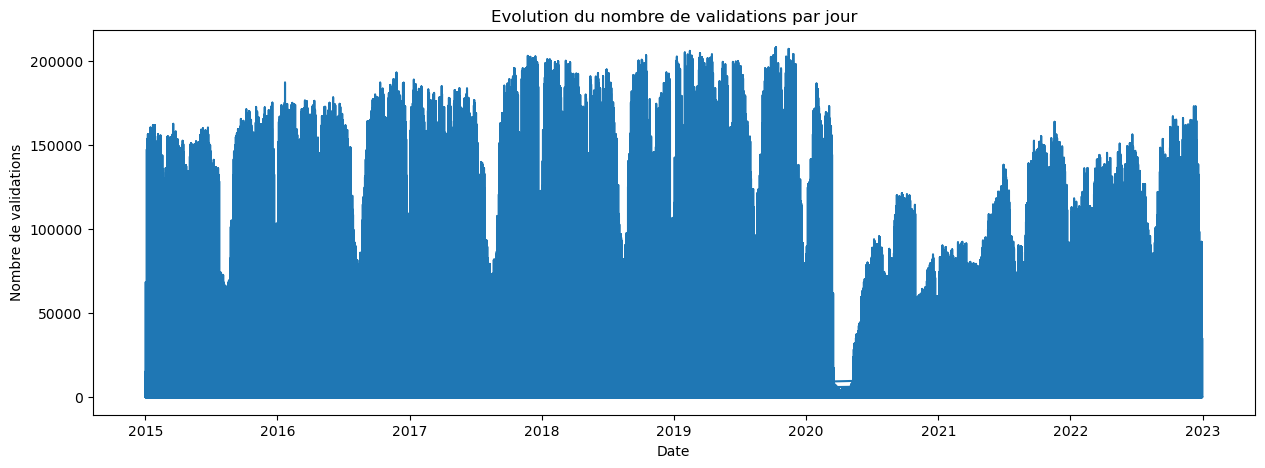

In [6]:
plt.figure(figsize=(15, 5))
plt.plot(X_train['date'], y_train['y'])
plt.title('Evolution du nombre de validations par jour')
plt.xlabel('Date')
plt.ylabel('Nombre de validations')

Il y a beaucoup de données, on note qu'il est difficile de visualiser toutes les informations ensemble. 

Alors, concentrons-nous sur un cas précis:

Text(0, 0.5, 'Nombre de validations')

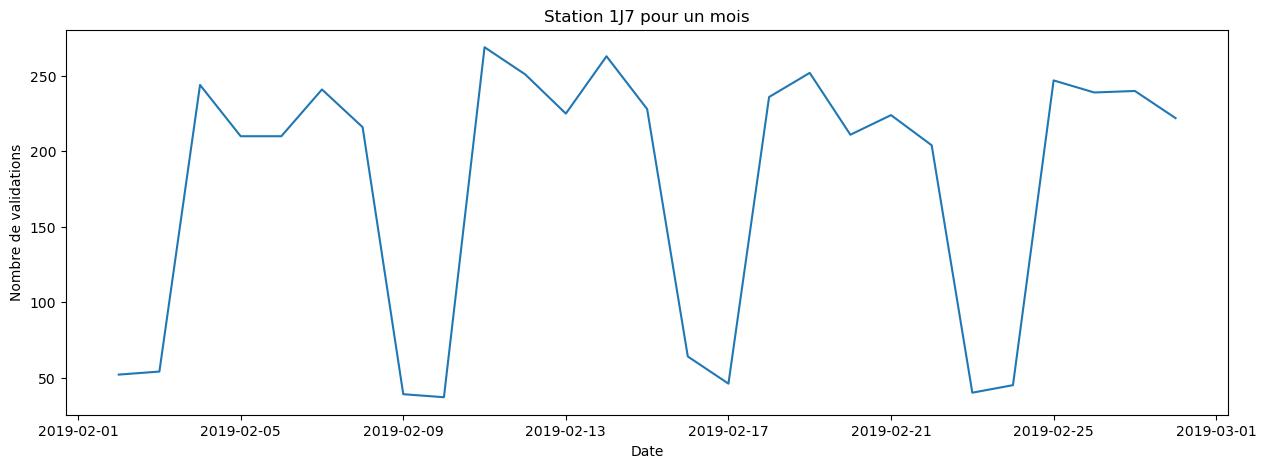

In [7]:
X_plot = X_train.loc[(X_train['date'] > '2019-02-01')
                     & (X_train['date'] < '2019-03-01')
                     & (X_train['station'] == '1J7')]
plt.figure(figsize=(15, 5))
plt.plot(X_plot['date'], y_train.loc[X_plot.index, 'y'])
plt.title('Station 1J7 pour un mois')
plt.xlabel('Date')
plt.ylabel('Nombre de validations')

On peut remarquer une relation de recurrence hebdomadaire, avec des pics de validations en semaine et des creux le week-end. 

### Ajout de nouvelles features

Pour enrichir les analyses, nous avons développé la fonction create_features_date(), qui décompose chaque date en plusieurs composantes comme le jour, le mois, l’année, et le jour de la semaine. Cela nous a permis de mieux analyser ces informations de manière séparée et de les utiliser pour affiner le modèle. 

En parallèle, nous avons développé la fonction create_features_lags() pour introduire des lags temporels comme nouvelles features. Après plusieurs tests (et en tenant en compte les tendances saisonnières), nous avons retenu les lags de 1 jour, 7 jours et 1 mois, car ils ont obtenu les meilleurs résultats en termes de score et figuraient parmi les plus importants dans les analyses d’importance des features (détaillées plus bas). Ces lags se sont révélés cruciaux pour capturer la nature des données temporelles, apportant des informations essentielles pour un entraînement optimal du modèle. 

Fonctions pour créer des features supplémentaires:

In [8]:
def create_features_date(df):
    ''' Create features from date '''
    df['day'] = df['date'].dt.day
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofweek'] = df['date'].dt.dayofweek
    return df

In [9]:
def create_features_lags(df_x, df_y):
    ''' Create lag features '''
    target_map = df_y['y'].to_dict()

    df_x['lagDay'] = (
        (df_x.date - pd.DateOffset(days=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)
    
    df_x['lagWeek'] = (
        (df_x.date - pd.DateOffset(days=7))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    df_x['lagMonth'] = (
        (df_x.date - pd.DateOffset(months=1))
        .dt.strftime('%Y-%m-%d') + '_' + df_x.station
    ).map(target_map)

    return df_x


In [10]:
X_train = create_features_date(X_train)
X_train = create_features_lags(X_train, y_train)
X_test = create_features_date(X_test)
X_test = create_features_lags(X_test, y_train)

### Visualisation et statistiques descriptives

Creation de boxplots pour visualiser la distribution des validations en fonction des jours de la semaine, des mois et des années:

<Axes: xlabel='year', ylabel='y'>

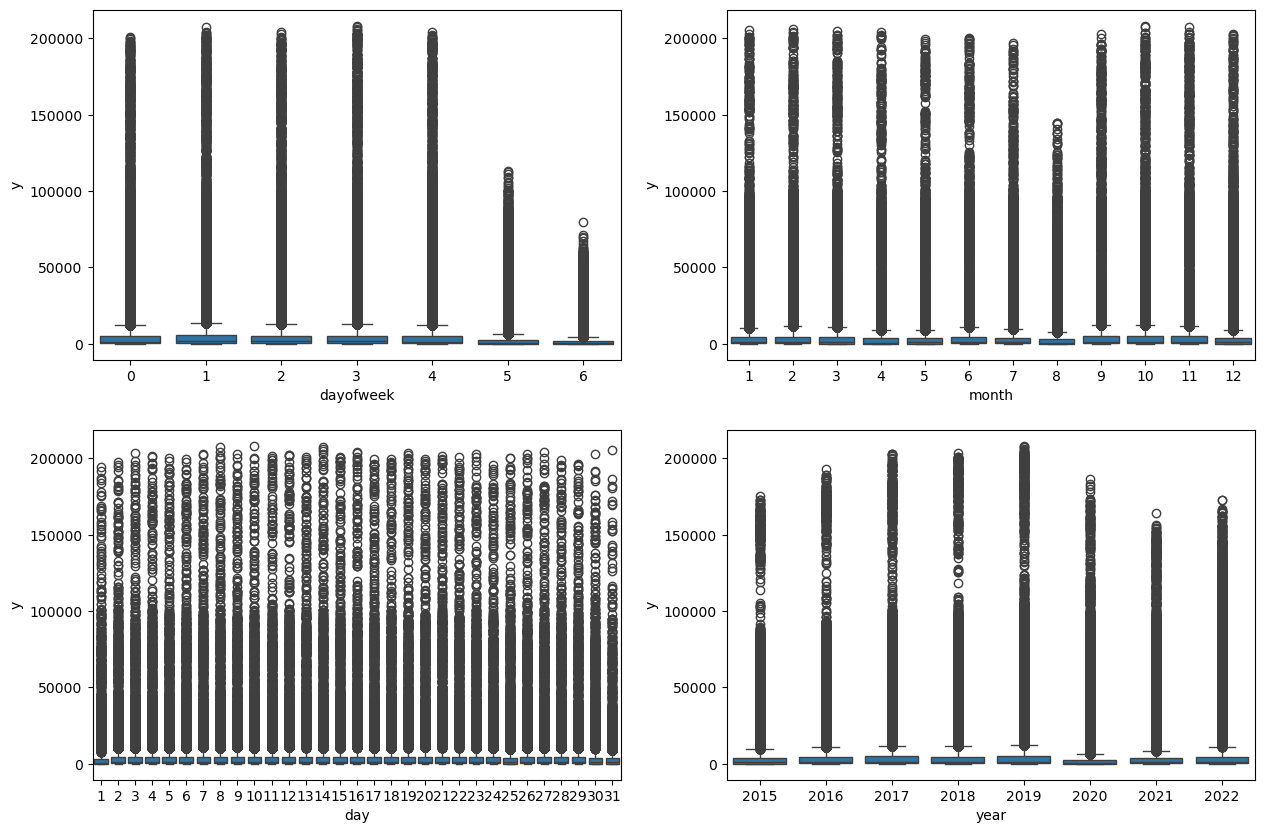

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x=X_train.dayofweek, y=y_train.y, ax=ax[0, 0])
sns.boxplot(x=X_train.month, y=y_train.y, ax=ax[0, 1])
sns.boxplot(x=X_train.day, y=y_train.y, ax=ax[1, 0])
sns.boxplot(x=X_train.year, y=y_train.y, ax=ax[1, 1])

On observe que les données sont concentrées autour de certaines valeurs, mais qu'il existe également de nombreux points de données éparpillés, ce qui complique l'interprétation du graphique. Pour avoir une vue plus claire, on trace un histogramme, en échelle logarithmique pour mieux visualiser:

Text(0.5, 1.0, 'Histogramme du nombre de validations')

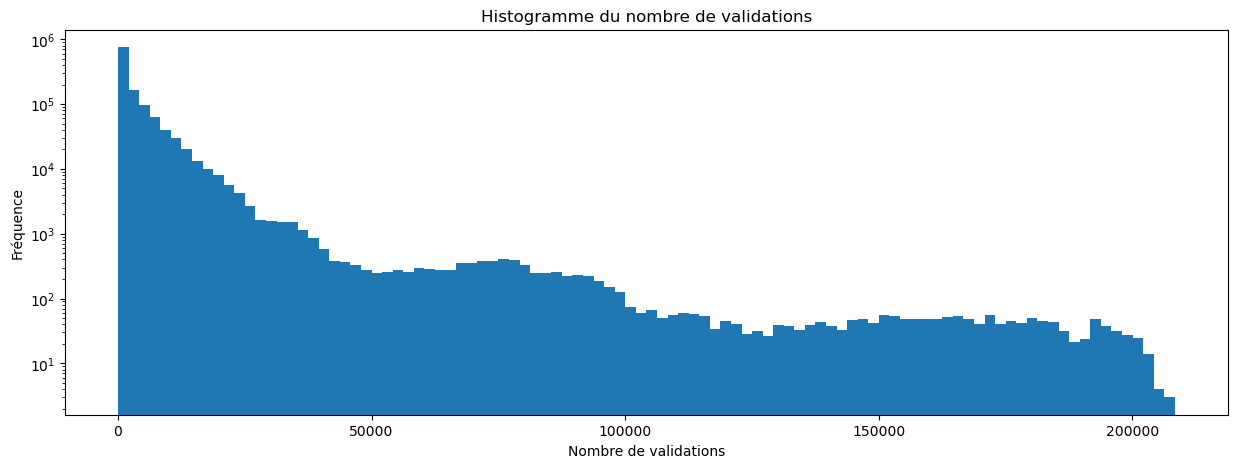

In [12]:
plt.figure(figsize=(15, 5))
plt.hist(y_train['y'], bins=100, log=True)
plt.xlabel('Nombre de validations')
plt.ylabel('Fréquence')
plt.title('Histogramme du nombre de validations')

On peut remarquer que la majorité des validations sont concentrées sur des valeurs relativement faibles, mais il y a encore une grande quantité de valeurs dispersées, en raison du nombre important de données collectées. 

Enfin, quelques statistiques descriptives pour le nombre de validations: 

In [13]:
y_train.describe()

,y
count,1.229863e+06
mean,3.930904e+03
std,9.683394e+03
min,0.000000e+00
25%,2.180000e+02
50%,1.108000e+03
75%,4.249000e+03
max,2.084090e+05


Bien que la plupart des valeurs de y soient relativement faibles (avec une médiane de 1 108), l'écart-type élevé (9 683,39) et la valeur maximale très élevée (208 409) indiquent qu'il existe des valeurs extrêmes qui influencent fortement la distribution, confirmant ce qui a été montré dans les boxplots. 

En continuant, afin d'optimiser les performances de notre modèle, on va:
- supprimer la colonne 'date', car nous avions déjà creé d'autres features temporelles qui contient ses informations; 
- convertir 'station' en une variable de type catégorie, afin que nous puissions utiliser certains modèles de machine learning.

In [14]:
# Supprime la colonne 'date' et convertit 'station' en catégorie
X_train = X_train.drop(columns=['date'])
X_train['station'] = X_train['station'].astype('category')

X_test = X_test.drop(columns=['date'])
X_test['station'] = X_test['station'].astype('category')

In [15]:
X_train.tail()

,station,job,ferie,vacances,day,month,year,dayofweek,lagDay,lagWeek,lagMonth
index,,,,,,,,,,,
2022-12-31_V2P,V2P,0,0,1,31,12,2022,5,1503.0,1063.0,2205.0
2022-12-31_N9K,N9K,0,0,1,31,12,2022,5,760.0,417.0,1568.0
2022-12-31_P6E,P6E,0,0,1,31,12,2022,5,112.0,74.0,350.0
2022-12-31_BDC,BDC,0,0,1,31,12,2022,5,70.0,53.0,51.0
2022-12-31_W14,W14,0,0,1,31,12,2022,5,19.0,10.0,59.0


## Modélisation

On commence la partie modélisation et entraînement des modèles.

On a testé plusieurs méthodes de machine learning différentes et analysé leurs performances. Après avoir comparé les résultats, on a constaté que les meilleurs scores étaient obtenus avec des modèles de boosting. Alors, on a décidé de concentrer nos efforts sur cette approche, en particulier sur le modèle LightGBM, qui s'est révélé être le plus efficace pour notre problème. 

Afin d'assurer une sélection optimale des paramètres, nous avons effectué un grid search. Il est important de remarquer que le grid search peut nécessiter des ajustements en fonction de cas spécifiques ou des capacités de calcul de votre machine.

In [16]:
estimator = lgb.LGBMRegressor(objective='poisson', random_state=42, max_bin=1000, max_depth=10, verbosity=-1)

param_grid = {
    'n_estimators': [700, 5000, 10000],
    'learning_rate': [0.1, 0.01]
}

grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',  
    cv= KFold(n_splits=3, shuffle=True),
    verbose=False,
    n_jobs=-1,
).fit(X_train, y_train, eval_set=[(X_train, y_train)])

print("\nBest params:", grid_search.best_params_)


Best params: {'learning_rate': 0.1, 'n_estimators': 10000}


Parcourir les résultats du grid search et afficher les scores moyens obtenus pour chaque combinaison de paramètres testée, pour bien analyser l'impact de chacune:

In [17]:
for p, i in zip(grid_search.cv_results_['params'], grid_search.cv_results_['mean_test_score']):
    print(f'Score {p}: {i}')

Score {'learning_rate': 0.1, 'n_estimators': 700}: -1596791.1737453884
Score {'learning_rate': 0.1, 'n_estimators': 5000}: -1268719.0385507275
Score {'learning_rate': 0.1, 'n_estimators': 10000}: -1245898.3582450498
Score {'learning_rate': 0.01, 'n_estimators': 700}: -2927834.718979772
Score {'learning_rate': 0.01, 'n_estimators': 5000}: -1523698.8079409155
Score {'learning_rate': 0.01, 'n_estimators': 10000}: -1349939.2999305895


On entraîne le modèle avec les meilleurs paramètres trouvés:

In [18]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train, eval_set=[(X_train, y_train)])

LGBMRegressor(max_bin=1000, max_depth=10, n_estimators=10000,
              objective='poisson', random_state=42, verbosity=-1)

On affiche les features importances, pour mieux comprendre quelles variables influencent le plus les prédictions du modèle.

<Axes: title={'center': 'Feature importance'}, ylabel='feature'>

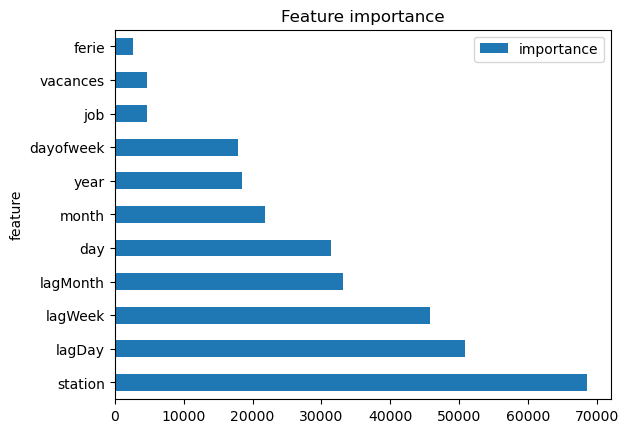

In [19]:
fi = pd.DataFrame({'feature': X_train.columns, 'importance': best_model.feature_importances_}).sort_values('importance', ascending=False)
fi.plot(kind='barh', x='feature', y='importance', title='Feature importance')

## Prediction et sauvegarde des résultats

On fait la prédiction sur les données de test et on sauvegarde les résultats dans un fichier csv:

In [21]:
# Prédiction sur le jeu de test
y_pred = pd.DataFrame(index=X_test.index)
y_pred_vals = best_model.predict(X_test)
y_pred['y'] = np.clip(y_pred_vals, 0, None).astype(int) # Clip les valeurs négatives à 0 (s'ils existent)
y_pred.to_csv('data/predictions/' + 'y_pred_lightGBM.csv') 

Si vous voulez, vous pouvez sauvegarder le model pour l'utiliser plus tard:

In [ ]:
# Sauvegarde du modèle
#estimator.save_model(file_path + 'model.json')